In [162]:
import datetime

import netCDF4
import pandas as pd
import xarray as xr
import matplotlib as mpl
import cdsapi
import numpy as np
import seaborn as sns
import warnings
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
from tabulate import tabulate
plt.style.use('mpl15')
import cftime
import cartopy.crs as ccrs
import pvlib
from global_land_mask import globe

#xr.set_options(display_style="html")

In [163]:
%%time
# Here, we use the ERA5 data and the Python API interface to cdsapi.
#
# https://www.ecmwf.int/sites/default/files/elibrary/2015/18490-radiation-quantities-ecmwf-model-and-mars.pdf
# ERA5, Monthly Means of Daily Forecast Accumulations
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form
def get_era5(station, step):
    c = cdsapi.Client()

    years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010',
             '2011','2012','2013','2014','2015','2016','2017','2018','2019']

    c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis_by_hour_of_day',
        'variable': [
            'clear_sky_direct_solar_radiation_at_surface',
            'downward_uv_radiation_at_the_surface',
            'surface_solar_radiation_downward_clear_sky',
            'surface_solar_radiation_downwards',
        ],
        'year': ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009'],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            90, -180, 50,
            180,
        ],
        'format': 'netcdf',
    },
        "../oceanography/light/ncfiles/ERA5_global_hourly_shortwave.nc")

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


In [164]:
%%time
stations=[{"name":"Chukchi_sea",
           "lat":69.25,
           "lon":-171}]

for i, station in enumerate(stations):
    step=3
    #get_era5(station, step)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [165]:
def convert_to_180(ds):
    return ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')



In [166]:
def get_era5(era_datafile, start_time, end_time):
    era = netCDF4.Dataset(era_datafile)
    print(era)
    units = 'hours since 1900-01-01 00:00:00.0'
    time_gregorian = cftime.num2date(era.variables["time"], units, 'gregorian')
    units_to_wm2 =1./3600.

    times=[]
    for t in time_gregorian:
        obj = datetime.datetime(year=t.year, month=t.month, day=t.month, hour=t.hour)
        times.append(obj)
    times = pd.to_datetime(times,dayfirst=False)

    era = xr.open_dataset(era_datafile,
                          mask_and_scale=True)*units_to_wm2

    era = era.assign_coords({"time":times,"latitude":era.latitude,"longitude":era.longitude})
    return era.rename({"latitude":"lat", "longitude":"lon"}).sel(time=slice(start_time,end_time))

def get_mean_era5(era_datafile, start_time, end_time):
    era = netCDF4.Dataset(era_datafile)

    units = 'hours since 1900-01-01 00:00:00.0'
    time_gregorian = cftime.num2date(era.variables["time"], units, 'gregorian')
    units_to_wm2 =1.

    times=[]
    for t in time_gregorian:
        obj = datetime.datetime(year=t.year, month=t.month, day=t.month, hour=t.hour)
        times.append(obj)
    times = pd.to_datetime(times,dayfirst=False)

    era = xr.open_dataset(era_datafile,
                          mask_and_scale=True)*units_to_wm2

    era = era.assign_coords({"time":times,"latitude":era.latitude,"longitude":era.longitude})
    return era.rename({"latitude":"lat", "longitude":"lon"}).sel(time=slice(start_time,end_time))

In [167]:
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

def get_area_averaged_ds(fname,min_lat,max_lat,min_lon,max_lon,var_name):

    with xr.open_dataset(fname) as ds:
     #   ds=convert_to_180(ds)
        ds=ds.sel(time=slice(start_time,end_time)).sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
        lon_c,lat_c=np.meshgrid(ds.lon.values,ds.lat.values)
        is_in_ocean_c = globe.is_ocean(lat_c,lon_c)
        ds.coords['mask'] = (('lat', 'lon'), is_in_ocean_c)

        ds = ds[var_name].where(ds.mask==1).fillna(0)
        ds = ds.mean({"lat","lon"})
       # ds = ds.resample(time="MS").mean()
        df = ds.to_dataframe().dropna()
        df = df.reset_index()
        return df

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-06-02 01:38:36 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data1/adaptor.mars.internal-1622596239.3499503-13803-5-16882e67-daa1-454e-8d86-18bfa63f69eb.nc /cache/tmp/16882e67-daa1-454e-8d86-18bfa63f69eb-adaptor.mars.internal-1622596239.3505805-13803-2-tmp.grib
    dimensions(sizes): longitude(1440), latitude(161), time(2880)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 cdir(time, latitude, longitude), int16 uvb(time, latitude, longitude), int16 ssrdc(time, latitude, longitude), int16 ssrd(time, latitude, longitude)
    groups: 
Correlation ghi   -0.129186
dtype: float64
CPU times: user 21.6 s, sys: 23 s, total: 44.5 s
Wall time: 47.4 s


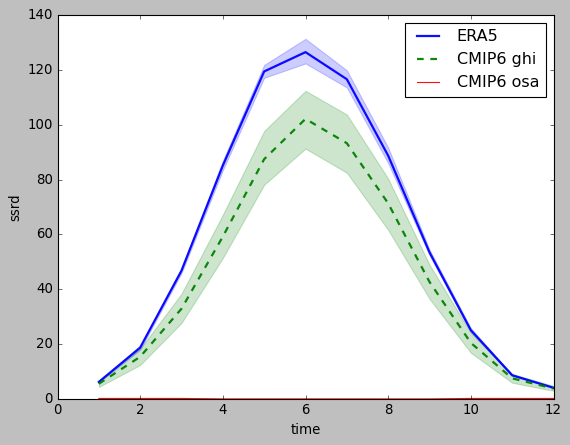

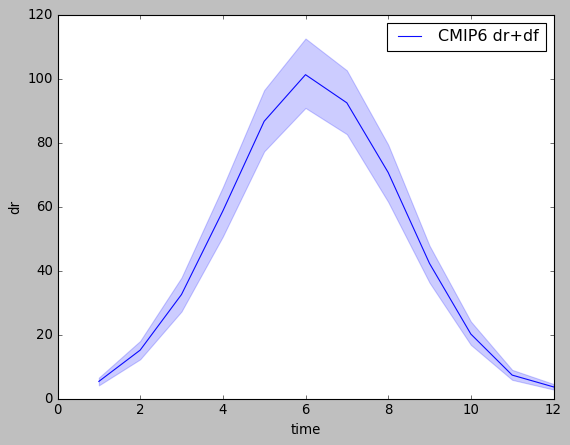

In [168]:
%%time
scenarios=["ssp585"]
ensemble_id="r1i1p1f1"
period="2000-01-01-2009-12-16"
start_time="2000-01-01"
end_time="2009-12-16"

models=["ACCESS-ESM1-5"]
era_var_name="ssrd"
#era_var_name="msdwswrf"
ds_var_name1="ghi"
ds_var_name2="osa"
ds_var_name3="drair"
ds_var_name4="dfair"

area_name= "Southern Norway" #"North and East Barents Sea" #"Gulf of Alaska" # #"Southern Norway" #"North and East Barents Sea" #"Gulf of Alaska" #"North and East Iceland" #"North and East Barents Sea" #"High Arctic Archipelago"
region_code=2
# Converting units see here:
# https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Monthlymeans
do_map=True

era_datafile="../oceanography/light/ncfiles/ERA5_global_hourly_shortwave.nc"
#era_datafile="../oceanography/light/ncfiles/ERA5_global_shortwave.nc"

era = get_era5(era_datafile, start_time, end_time)
#era = get_mean_era5(era_datafile, start_time, end_time)

#distance = haversine(lon1,lat1,lon2,lat2)

min_lat=50
max_lat=70
min_lon=0
max_lon=18
era = era.reindex(lat=list(reversed(era.lat)))
era = era.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon))

lon1,lat1=np.meshgrid(era.lon.values,era.lat.values)
is_in_ocean = globe.is_ocean(lat1,lon1)
era.coords['mask'] = (('lat', 'lon'), is_in_ocean)

era = era[era_var_name].where(era.mask==1).fillna(0)
era = era.mean({"lat","lon"})
era = era.resample(time="MS", loffset=pd.Timedelta(14, 'd')).mean()

for i, station in enumerate(stations):

    era_df=era.to_dataframe().reset_index()

    for scenario in scenarios:
        for model in models:
            fname="../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_osa_{}.nc".format(ds_var_name1, model, ensemble_id,period,scenario)

            df1 = get_area_averaged_ds(fname,min_lat,max_lat,min_lon,max_lon,ds_var_name1)

            fname2="../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_osa_{}.nc".format(ds_var_name2,model, ensemble_id,period,scenario)
            df2 = get_area_averaged_ds(fname2,min_lat,max_lat,min_lon,max_lon,ds_var_name2)

            fname3="../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_osa_{}.nc".format(ds_var_name3,model, ensemble_id,period,scenario)
            df3 = get_area_averaged_ds(fname3,min_lat,max_lat,min_lon,max_lon,ds_var_name3)

            fname4="../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_osa_{}.nc".format(ds_var_name4,model, ensemble_id,period,scenario)
            df4 = get_area_averaged_ds(fname4,min_lat,max_lat,min_lon,max_lon,ds_var_name4)

            df3["dr"]=df3[ds_var_name3]+df4[ds_var_name4]
            fig3, axes3 = plt.subplots(1, 1)
            sns.lineplot(ax=axes3, data=era_df, x=era_df.time.dt.month,
                         y=era_var_name, #hue=era_df.time.dt.month,
                         ci=95, alpha=0.95,
                             legend="auto", label="ERA5", linewidth=2)
            sns.lineplot(ax=axes3, data=df1, x=df1.time.dt.month, y=ds_var_name1,
                         ci=95, alpha=0.95,#hue=df1.time.dt.month,
                         legend="auto", label="CMIP6 {}".format(ds_var_name1), linewidth=2, linestyle="--")
            sns.lineplot(ax=axes3, data=df2, x=df2.time.dt.month, y=ds_var_name2,
                         ci=95, alpha=0.95,
                         legend="auto", label="CMIP6 {}".format(ds_var_name2))

            fig2, axes2 = plt.subplots(1, 1)
            sns.lineplot(ax=axes2, data=df3, x=df3.time.dt.month, y="dr", #hue=df3.time.dt.month,
                         ci=95, alpha=0.95,
                         legend="auto", label="CMIP6 dr+df")
            print("Correlation", df1.corrwith(era_df[era_var_name]))